In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from util_functions import plot_feature_with_anomalies, remove_outliers, remove_outliers_iqr

In [2]:
# Set Pandas to display all columns (None means no limit on the number of columns displayed)
pd.set_option('display.max_columns', None)

# Set option to display float format
pd.set_option('display.float_format', lambda x: '%.3f' % x) # This will help avoid issue of numeric values that are in the form of power (scientific notation) when you load them with pandas

In [3]:
# Function to check if variable is defined
def is_defined(variable_name):
    return variable_name in globals()

# Initial file paths
dasiv01 = 'Original_labeled_datasets/dt1_solar_and_meteorological_measurement.csv'
dasiv02 = 'Original_labeled_datasets/dt2_electrical_production_inverter_1_with_faults.csv'

# load the data if it is not already loaded
while not (is_defined('weather_data') and is_defined('df1')):
            weather_data = pd.read_csv(dasiv01, index_col='time')
            print("Weather data loaded successfully.")

            df1 = pd.read_csv(dasiv02, index_col='time')
            print("Electrical production data loaded successfully.")

df = df1.copy()
weather = weather_data.copy()

Weather data loaded successfully.
Electrical production data loaded successfully.


In [4]:
df = df.join(weather)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_convert(None) # Remove timezone information to avoid issues with decomposition

In [5]:
# Resample data to have different time intervals
df = df.resample('10min').agg({
    'GTI': 'mean',
    'DTI': 'mean',
    'TA': 'mean',
    'TPV': 'mean',
    'Eg': 'sum',
    'Pg': 'mean',
    'Ia': 'mean',
    'Ig': 'mean',
    'Va': 'mean',
    'Vg': 'mean',
    'Fg': 'mean',
    'Fault': 'mean'
})

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [6]:
# rename the columns
df.rename(columns={'GTI': 'global_tilted_irradiance', 
                   'DTI': 'diffuse_tilted_irradiance', 
                   'TA': 'ambient_temperature', 
                   'TPV': 'panel_temperature', 
                   'Eg': 'energy_injected',
                   'Pg': 'power_injected', 
                   'Ia': 'ambient_current', 
                   'Ig': 'current_injected',
                   'Va': 'pv_plant_voltage',
                   'Vg': 'grid_voltage',
                   'Fg': 'grid_frequency'}, inplace=True)

### After resampling, the values in Fault column were affected, which is not recommended. I will round it.

In [7]:
df['Fault'] = df['Fault'].round()
non_zero_rows = df['Fault'].astype(bool).sum()
print("Number of rows with non-zero values in the 'Fault' column:", non_zero_rows)

Number of rows with non-zero values in the 'Fault' column: 803


<Axes: >

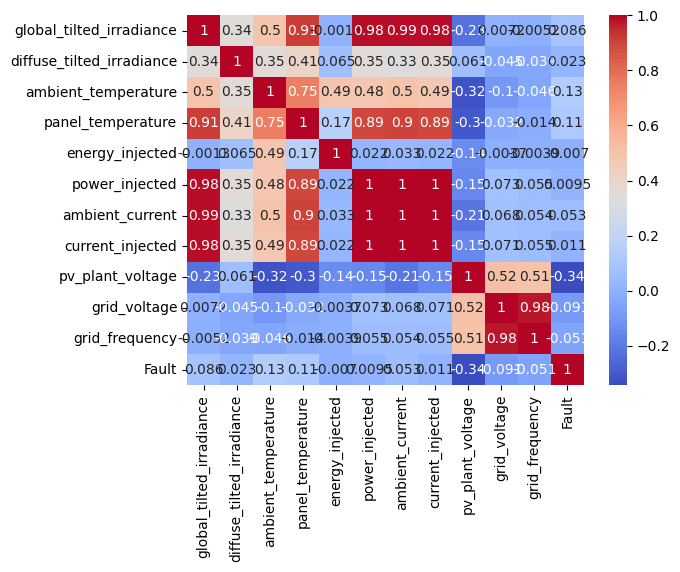

In [8]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### Change the values of Fault column. Set the values to 1 if they are not equal to 0.

In [9]:
# convert other fault types to 1
df['Fault'] = df['Fault'].apply(lambda x: 1 if x != 0 else 0)

### Reorder the columns

In [10]:
# Get all column names except 'fault'
cols = [c for c in df.columns if c != 'Fault']

# Append 'fault' column at the end
cols.append('Fault')

# Reorder the DataFrame using the new column order
df = df[cols]

#### Apply de-trending and de-seasoning

In [11]:
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller, kpss

# df_for_decomposition = df.copy()

# full_index = pd.date_range(start='2021-10-27', end='2023-04-14', freq='10min')  # Fill in the gaps in the index of the data. '10T' for 10-minute intervals. 

# # Reindex the DataFrame, you can choose a method to handle missing values
# df_for_decomposition = df_for_decomposition.reindex(full_index, method='nearest')  # or use fillna() method after reindexing

# for column in df_for_decomposition.drop('Fault', axis=1).columns:
#     if kpss(df_for_decomposition[column])[1] > 0.05:  # If the time series is not stationary
#         decomposed_column = sm.tsa.seasonal_decompose(df_for_decomposition[column], period=144)  # 144 periods is equivalent to 24 hours (144 * 10 minutes = 24 hours
#         trend = decomposed_column.trend
#         df_for_decomposition[column] = df_for_decomposition[column] - trend # Remove the trend from the original time series

# # Update the original DataFrame with the decomposed values
# df.update(df_for_decomposition.drop('Fault', axis=1))


#### Address outliers by capping their values

In [12]:
# address outliers by capping their values
# df = remove_outliers_iqr(df)
df = remove_outliers(df, lower_percentile=0.001, upper_percentile=0.999)

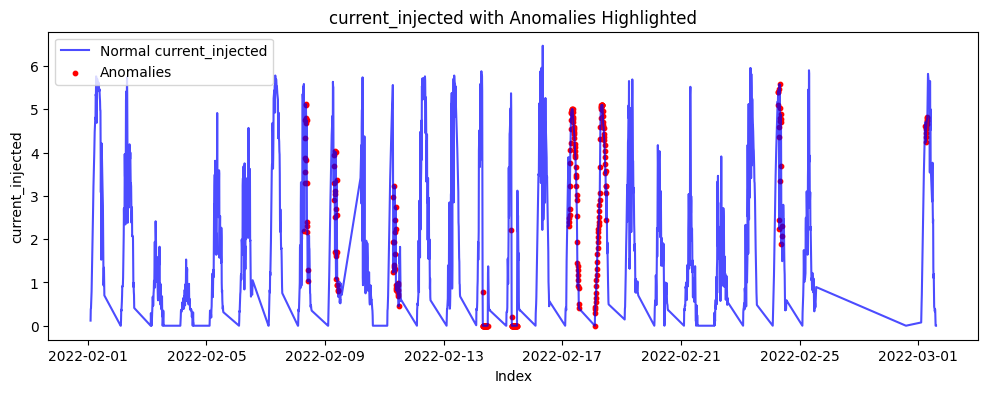

In [13]:
plot_feature_with_anomalies(df["2022-02-01":'2022-03-01'], 'current_injected')

In [16]:
# choose the directory of where GNNAD_testing files are located
df[:'2022-07-01'].to_csv('for_cross_validation.csv', index=True)